In [1]:
import gym
import sys
import time
import numpy as np
import matplotlib.pyplot as plt

from six import StringIO
from gym import utils
from gym.envs.toy_text import discrete
from gym.envs.registration import register

# ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
def run_policy(env, policy, gamma, max_iter=int(1e3), render=False):
    obs = env.reset()
    total_reward, step_idx = 0, 0
    while True:
        if render:
            env.render()
        obs, reward, done , _ = env.step(int(policy[obs]))
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done or step_idx > max_iter: break
    return total_reward

def eval_policy(env, policy, gamma, n=1000):
    scores = [run_policy(env, policy, gamma) for _ in range(n)]
    return np.mean(scores)

In [3]:
# value iter
class ValueIter(object):
    def __init__(self, env, gamma, max_iter=int(1e6), eps=1e-20):
        self.env = env
        self.gamma = gamma
        self.max_iter = max_iter
        self.eps = eps
        self.reset_env()
        
    def reset_env(self, seed=0):
        self.env.seed(seed)
        self.env.reset()
        
    def value_iter(self):
        val_optim = np.zeros(self.env.nS) # init value
        ldelta, lreward, ltime = [], [], [] # init stats

        # iter episode
        for i in range(self.max_iter):
            reward_tmp = 0.
            start_time = time.clock()
            val_tmp = np.copy(val_optim)
            
            # iter each state
            for s in range(self.env.nS):
                q_sa = [sum([p * (r + self.gamma * val_tmp[snew]) for p, snew, r, _ in self.env.P[s][a]]) for a in range(self.env.nA)] 
                val_optim[s] = max(q_sa)
                reward_tmp += max(q_sa)
                
            # record reward
            lreward.append(reward_tmp)
                
            # record delta
            delta_tmp = np.sum(np.fabs(val_tmp - val_optim))
            ldelta.append(delta_tmp)
            
            # record time
            ltime.append(time.clock() - start_time)
            
            # break conditionn
            if delta_tmp <= self.eps: break
                
        return val_optim, ldelta, lreward, ltime
    
    def get_policy(self, val):
        policy = np.zeros(self.env.nS)
        for s in range(self.env.nS):
            q_sa = np.zeros(self.env.action_space.n)
            for a in range(self.env.action_space.n):
                for next_sr in self.env.P[s][a]:
                    p, snew, r, _ = next_sr
                    q_sa[a] += (p * (r + self.gamma * val[snew]))
            policy[s] = np.argmax(q_sa)
        return policy
       
    def plot(self, ldelta, lreward, ltime):      
        fig, ax1 = plt.subplots()
        ax1.plot(list(range(len(ldelta))), ldelta, 'dodgerblue')
        ax1.set_xlabel('iteration')
        ax1.set_ylabel('delta', color='dodgerblue')
        ax1.tick_params('y', colors='dodgerblue')

        ax2 = ax1.twinx()
        ax2.plot(list(range(len(lreward))), lreward, 'brown')
        ax2.set_ylabel('reward', color='brown')
        ax2.tick_params('y', colors='brown')

        fig.tight_layout()
        plt.show()

        plt.figure()
        plt.plot(list(range(len(ltime))), ltime)
        plt.xlabel('iteration')
        plt.ylabel('time')
        fig.tight_layout()
        plt.show()

In [4]:
# policy iter
class PolicyIter(object):
    def __init__(self, env, gamma, max_iter=int(1e6), eps=1e-20):
        self.env = env
        self.gamma = gamma
        self.max_iter = max_iter
        self.eps = eps
        self.reset_env()
        
    def reset_env(self, seed=0):
        self.env.seed(seed)
        self.env.reset()
        np.random.seed(seed)

    def compute_policy(self, policy):
        v = np.zeros(self.env.nS)
        reward_tmp = 0.
        start_time = time.clock()
        while True:
            prev_v = np.copy(v)
            for s in range(self.env.nS):
                policy_a = policy[s]
                v[s] = sum([p * (r + self.gamma * prev_v[snew]) for p, snew, r, _ in self.env.P[s][policy_a]])
                reward_tmp += np.max(v[s])
            if np.sum((np.fabs(prev_v - v))) <= self.eps: break
        return v, reward_tmp, time.clock() - start_time

    def policy_iter(self):
        ldelta, lreward, ltime = [], [], [] # init stats
        policy_optim = np.random.choice(self.env.nA, size=(self.env.nS))
        
        for i in range(self.max_iter):
            val_tmp, reward_tmp, time_tmp = self.compute_policy(policy_optim)
            policy_tmp = self.get_policy(val_tmp)
            delta_tmp = np.sum((np.fabs(policy_optim - policy_tmp)))
            if delta_tmp < self.eps: break
            policy_optim = policy_tmp
            
            lreward.append(reward_tmp) # record reward        
            ldelta.append(delta_tmp) # record delta
            ltime.append(time_tmp) # record time
            
        return policy_optim, ldelta, lreward, ltime
    
    def get_policy(self, val):
        policy = np.zeros(self.env.nS)
        for s in range(self.env.nS):
            q_sa = np.zeros(self.env.action_space.n)
            for a in range(self.env.action_space.n):
                for next_sr in self.env.P[s][a]:
                    p, snew, r, _ = next_sr
                    q_sa[a] += (p * (r + self.gamma * val[snew]))
            policy[s] = np.argmax(q_sa)
        return policy
    
    def plot(self, ldelta, lreward, ltime):
        fig, ax1 = plt.subplots()
        ax1.plot(list(range(len(ldelta))), ldelta, 'dodgerblue')
        ax1.set_xlabel('iteration')
        ax1.set_ylabel('delta', color='dodgerblue')
        ax1.tick_params('y', colors='dodgerblue')

        ax2 = ax1.twinx()
        ax2.plot(list(range(len(lreward))), lreward, 'brown')
        ax2.set_ylabel('reward', color='brown')
        ax2.tick_params('y', colors='brown')

        fig.tight_layout()
        plt.show()

        plt.figure()
        plt.plot(list(range(len(ltime))), ltime)
        plt.xlabel('iteration')
        plt.ylabel('time')
        fig.tight_layout()
        plt.show()

In [5]:
# Q learning
class QLearning(object):
    def __init__(self, env, gamma, alpha, episodes, num_iter):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.episodes = episodes
        self.num_iter = num_iter

    def q_learn(self, verbose=True):    
        Q = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        lreward = []
        for episode in range(1, self.episodes):
            s = self.env.reset()
            done = False
            rAll, counter = 0, 0
            while counter < self.num_iter:
                counter += 1
                a = np.argmax(Q[s, :] + np.random.randn(1, self.env.action_space.n) * (1. / (episode + 1)))
                s1, r, done, _ = self.env.step(a)
                Q[s,a] = Q[s,a] + self.alpha*(r + self.gamma*np.max(Q[s1,:]) - Q[s,a])
                rAll += r
                s = s1
                if done == True:
                    break
            lreward.append(rAll)
            if verbose:
                msg = 'Episode: {} Average reward: {:.2f}'.format(episode, rAll)
                print(msg, end='\r')
            
        return Q, lreward
    
    def get_policy(self, Q):
        policy = np.zeros(self.env.nS)
        for s in range(self.env.nS):
            policy[s] = np.argmax(Q[s, :])
        return policy
    
    def gen_chunk(self, reward_list, chunk_size):
        for i in range(0, len(reward_list), chunk_size):
            yield reward_list[i: i + chunk_size]
        
    def get_avg_reward(self, lreward, size=100):
        chunks = list(self.gen_chunk(lreward, size))
        avg_rewards = [sum(chunk) / len(chunk) for chunk in chunks]
        return list(range(0, len(lreward), size)), avg_rewards
    
    def plot(self, lreward, size=5000):
        epis, avg_reward = self.get_avg_reward(lreward, size)
        plt.figure()
        plt.plot(epis, avg_reward)
        plt.xlabel('episode')
        plt.ylabel('average reward')
        plt.show()

### FrozenLake0

In [6]:
fl0_env = gym.make('FrozenLake-v0')
fl0_env = fl0_env.unwrapped

#### value iteration

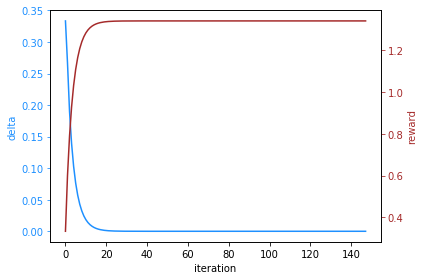

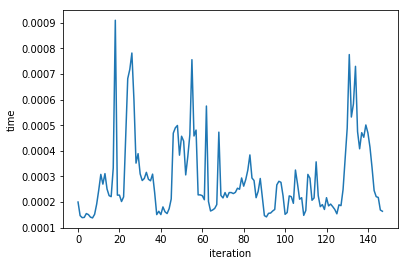

In [7]:
obj_vi_fl0 = ValueIter(env=fl0_env, gamma=0.8)
val_vi_fl0, ldelta_vi_fl0, lreward_vi_fl0, ltime_vi_fl0 = obj_vi_fl0.value_iter()
obj_vi_fl0.plot(ldelta_vi_fl0, lreward_vi_fl0, ltime_vi_fl0)

In [8]:
policy_vi_fl0 = obj_vi_fl0.get_policy(val_vi_fl0)
print('policy: ',policy_vi_fl0)
print('avg_score: ',eval_policy(env=fl0_env, policy=policy_vi_fl0, gamma=0.8))
run_policy(env=fl0_env, policy=policy_vi_fl0, gamma=0.8,render=True)

policy:  [2. 3. 2. 3. 0. 0. 0. 0. 3. 1. 0. 0. 0. 2. 1. 0.]
avg_score:  0.016678135717350696

SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
H

0.0

#### policy iteration

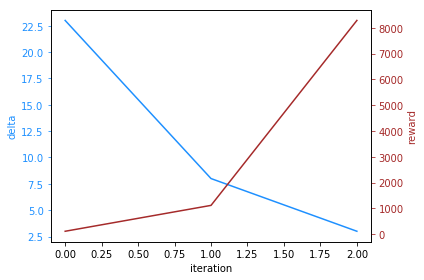

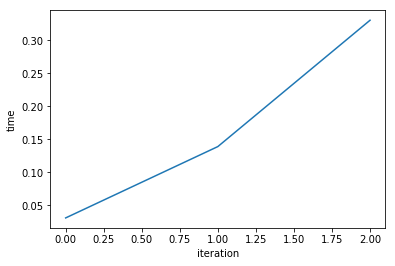

In [9]:
obj_pi_fl0 = PolicyIter(env=fl0_env, gamma=1.0)
policy_pi_fl0, ldelta_pi_fl0, lreward_pi_fl0, ltime_pi_fl0 = obj_pi_fl0.policy_iter()
obj_pi_fl0.plot(ldelta_pi_fl0, lreward_pi_fl0, ltime_pi_fl0)

In [10]:
print('policy: ',policy_pi_fl0)
print('avg_score: ',eval_policy(env=fl0_env, policy=policy_pi_fl0, gamma=1.0))
run_policy(env=fl0_env, policy=policy_pi_fl0, gamma=1.0,render=True)

policy:  [0. 3. 3. 3. 0. 0. 0. 0. 3. 1. 0. 0. 0. 2. 1. 0.]
avg_score:  0.85

SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (L

1.0

#### Q learning

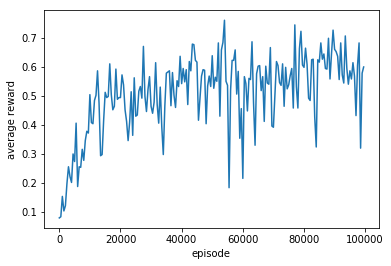

In [11]:
obj_q_fl0 = QLearning(env=fl0_env, gamma=0.8, alpha=0.9, episodes=int(1e5), num_iter=100)
q_q_fl0, lreward_q_fl0 = obj_q_fl0.q_learn(verbose=False)
obj_q_fl0.plot(lreward_q_fl0, size=500)

In [12]:
policy_q_fl0 = obj_q_fl0.get_policy(q_q_fl0)
print('policy: ',policy_q_fl0)
print('avg_score: ',eval_policy(env=fl0_env, policy=policy_q_fl0, gamma=0.8))
run_policy(env=fl0_env, policy=policy_q_fl0, gamma=0.8,render=True)

policy:  [0. 0. 1. 0. 0. 0. 0. 0. 3. 1. 0. 0. 0. 2. 1. 0.]
avg_score:  0.015711667295037153

SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Left)

9.13438523331817e-06

### FrozenLake1

In [13]:
register(
    id='FrozenLakeLarge-v1',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '8x8', 'is_slippery': True},
)

In [14]:
fl1_env = gym.make('FrozenLakeLarge-v1')
fl1_env = fl1_env.unwrapped

#### value iteration

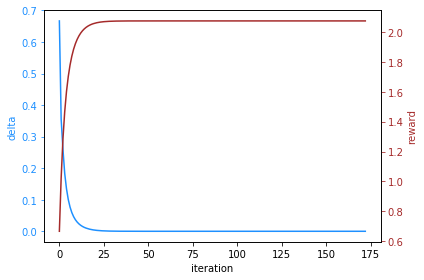

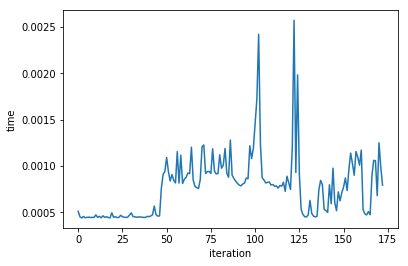

In [15]:
obj_vi_fl1 = ValueIter(env=fl1_env, gamma=0.8)
val_vi_fl1, ldelta_vi_fl1, lreward_vi_fl1, ltime_vi_fl1 = obj_vi_fl1.value_iter()
obj_vi_fl1.plot(ldelta_vi_fl1, lreward_vi_fl1, ltime_vi_fl1)

In [16]:
policy_vi_fl1 = obj_vi_fl1.get_policy(val_vi_fl1)
print('policy: ',policy_vi_fl1)
print('avg_score: ',eval_policy(env=fl1_env, policy=policy_vi_fl1, gamma=0.8))
run_policy(env=fl1_env, policy=policy_vi_fl1, gamma=0.8,render=True)

policy:  [3. 2. 2. 2. 2. 2. 2. 2. 3. 2. 2. 3. 2. 2. 2. 1. 3. 2. 0. 0. 2. 3. 2. 1.
 3. 3. 3. 1. 0. 0. 2. 1. 3. 3. 0. 0. 2. 1. 3. 2. 0. 0. 0. 1. 3. 0. 0. 2.
 0. 0. 1. 0. 0. 0. 0. 2. 1. 1. 0. 0. 1. 1. 1. 0.]
avg_score:  0.0001681499448292556

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFF

0.0

#### policy iteration

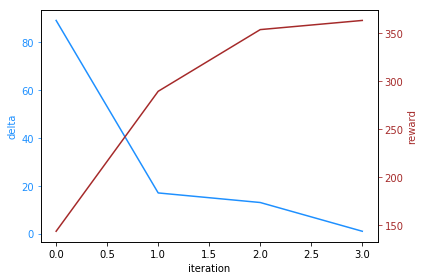

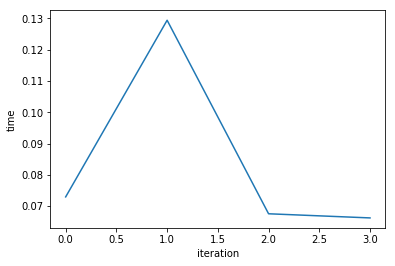

In [17]:
obj_pi_fl1 = PolicyIter(env=fl1_env, gamma=0.8)
policy_pi_fl1, ldelta_pi_fl1, lreward_pi_fl1, ltime_pi_fl1 = obj_pi_fl1.policy_iter()
obj_pi_fl1.plot(ldelta_pi_fl1, lreward_pi_fl1, ltime_pi_fl1)

In [18]:
print('policy: ',policy_pi_fl1)
print('avg_score: ',eval_policy(env=fl1_env, policy=policy_pi_fl1, gamma=0.8))
run_policy(env=fl1_env, policy=policy_pi_fl1, gamma=0.8,render=True)

policy:  [3. 2. 2. 2. 2. 2. 2. 2. 3. 2. 2. 3. 2. 2. 2. 1. 3. 2. 0. 0. 2. 3. 2. 1.
 3. 3. 3. 1. 0. 0. 2. 1. 3. 3. 0. 0. 2. 1. 3. 2. 0. 0. 0. 1. 3. 0. 0. 2.
 0. 0. 1. 0. 0. 0. 0. 2. 1. 1. 0. 0. 1. 1. 1. 0.]
avg_score:  0.0001681499448292556

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFF

0.0

#### q learning

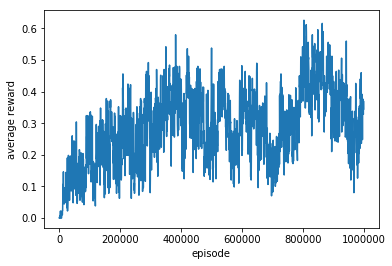

In [19]:
obj_q_fl1 = QLearning(env=fl1_env, gamma=0.8, alpha=0.9, episodes=int(1e6), num_iter=100)
q_q_fl1, lreward_q_fl1 = obj_q_fl1.q_learn(verbose=False)
obj_q_fl1.plot(lreward_q_fl1, size=500)

In [20]:
policy_q_fl1 = obj_q_fl1.get_policy(q_q_fl1)
print('policy: ',policy_q_fl1)
print('avg_score: ',eval_policy(env=fl1_env, policy=policy_q_fl1, gamma=0.8))
run_policy(env=fl1_env, policy=policy_q_fl1, gamma=0.8,render=True)

policy:  [1. 1. 3. 1. 2. 2. 1. 0. 2. 1. 2. 3. 0. 2. 1. 2. 2. 0. 0. 0. 2. 3. 2. 0.
 3. 3. 3. 3. 2. 0. 2. 1. 2. 0. 0. 0. 2. 1. 3. 2. 0. 0. 0. 0. 3. 0. 0. 2.
 1. 0. 0. 3. 0. 0. 0. 2. 2. 1. 0. 0. 2. 2. 1. 0.]
avg_score:  5.5091454080422126e-05

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
  (Left)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFF

2.497398840252816e-16

### Taxi - v2

In [21]:
taxi_env = gym.make('Taxi-v2')
taxi_env = taxi_env.unwrapped

#### value iteration

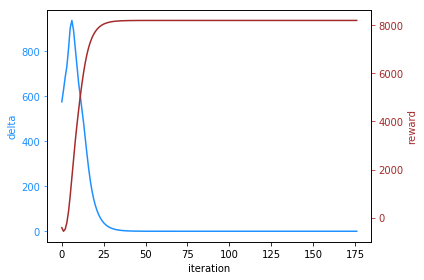

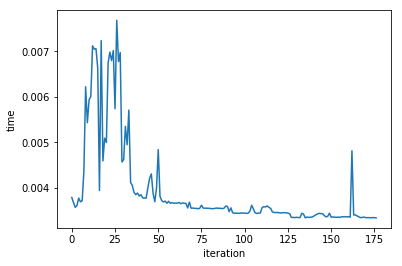

In [22]:
obj_vi_taxi = ValueIter(env=taxi_env, gamma=0.8)
val_vi_taxi, ldelta_vi_taxi, lreward_vi_taxi, ltime_vi_taxi = obj_vi_taxi.value_iter()
obj_vi_taxi.plot(ldelta_vi_taxi, lreward_vi_taxi, ltime_vi_taxi)

In [23]:
policy_vi_taxi = obj_vi_taxi.get_policy(val_vi_taxi)
print('policy: ',policy_vi_taxi)
print('avg_score: ',eval_policy(env=taxi_env, policy=policy_vi_taxi, gamma=0.8))
run_policy(env=taxi_env, policy=policy_vi_taxi, gamma=0.8,render=True)

policy:  [4. 4. 4. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 3. 3. 3. 3.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 4. 4. 4. 4. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 5. 0. 0. 1. 1. 1. 1. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0.
 1. 1. 1. 1. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 3. 3. 3. 3.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 3. 1. 0. 0. 3. 3. 3. 3. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 3. 1. 0. 0. 3. 3. 3. 3. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 3. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 2. 2. 2. 2.
 1. 1. 0. 2. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 2. 2. 2. 2. 1. 1. 3. 2.
 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 2. 2. 2. 2. 1. 1. 3. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 3. 3. 3. 3. 0. 0. 0. 0. 1. 1. 3. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 3. 3. 3. 3. 0. 0. 0. 0. 1. 1. 3. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.

-3.2820130816000006

#### policy iteration

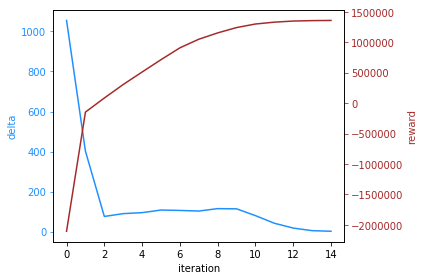

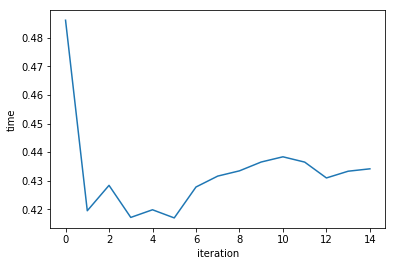

In [24]:
obj_pi_taxi = PolicyIter(env=taxi_env, gamma=0.8)
policy_pi_taxi, ldelta_pi_taxi, lreward_pi_taxi, ltime_pi_taxi = obj_pi_taxi.policy_iter()
obj_pi_taxi.plot(ldelta_pi_taxi, lreward_pi_taxi, ltime_pi_taxi)

In [25]:
print('policy: ',policy_pi_taxi)
print('avg_score: ',eval_policy(env=taxi_env, policy=policy_pi_taxi, gamma=0.8))
run_policy(env=taxi_env, policy=policy_pi_taxi, gamma=0.8,render=True)

policy:  [4. 4. 4. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 3. 3. 3. 3.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 4. 4. 4. 4. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 5. 0. 0. 1. 1. 1. 1. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0.
 1. 1. 1. 1. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 3. 3. 3. 3.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 3. 1. 0. 0. 3. 3. 3. 3. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 3. 1. 0. 0. 3. 3. 3. 3. 1. 1. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 3. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 2. 2. 2. 2.
 1. 1. 0. 2. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 2. 2. 2. 2. 1. 1. 3. 2.
 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 2. 2. 2. 2. 1. 1. 3. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 3. 3. 3. 3. 0. 0. 0. 0. 1. 1. 3. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 3. 3. 3. 3. 0. 0. 0. 0. 1. 1. 3. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.

-3.2820130816000006

#### q learning

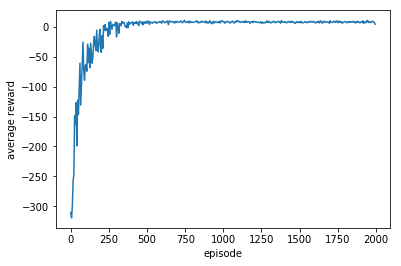

In [26]:
obj_q_taxi = QLearning(env=taxi_env, gamma=0.8, alpha=0.9, episodes=int(2e3), num_iter=100)
q_q_taxi, lreward_q_taxi = obj_q_taxi.q_learn(verbose=False)
obj_q_taxi.plot(lreward_q_taxi, size=5)

In [27]:
policy_q_taxi = obj_q_taxi.get_policy(q_q_taxi)
print('policy: ',policy_q_taxi)
print('avg_score: ',eval_policy(env=taxi_env, policy=policy_q_taxi, gamma=0.8))
run_policy(env=taxi_env, policy=policy_q_taxi, gamma=0.8,render=True)

policy:  [0. 4. 4. 4. 2. 0. 0. 2. 0. 0. 0. 0. 2. 0. 2. 0. 5. 2. 0. 0. 0. 3. 3. 3.
 0. 0. 0. 0. 3. 0. 0. 3. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 2. 0. 2. 2.
 0. 0. 0. 0. 0. 0. 2. 0. 0. 3. 0. 0. 0. 0. 0. 0. 2. 0. 2. 2. 0. 3. 0. 3.
 0. 0. 0. 0. 0. 2. 1. 1. 0. 3. 0. 3. 4. 0. 4. 4. 0. 3. 0. 0. 0. 0. 0. 0.
 3. 5. 0. 0. 0. 1. 1. 1. 2. 0. 2. 2. 0. 0. 0. 0. 0. 2. 0. 0. 1. 2. 0. 0.
 0. 1. 1. 1. 2. 0. 2. 0. 0. 3. 0. 1. 0. 2. 0. 0. 3. 2. 0. 0. 0. 3. 3. 3.
 2. 0. 2. 2. 3. 3. 0. 0. 3. 0. 2. 0. 3. 2. 3. 0. 0. 3. 3. 3. 2. 0. 2. 2.
 0. 3. 0. 3. 0. 0. 0. 0. 3. 2. 3. 0. 0. 0. 3. 3. 1. 0. 1. 1. 3. 0. 0. 3.
 3. 0. 3. 0. 0. 1. 3. 0. 0. 1. 1. 1. 2. 0. 2. 2. 0. 0. 0. 0. 2. 2. 2. 0.
 1. 2. 0. 2. 0. 1. 3. 1. 1. 0. 1. 2. 3. 3. 0. 3. 2. 2. 2. 0. 0. 1. 3. 2.
 0. 3. 3. 3. 2. 0. 1. 2. 3. 3. 0. 3. 2. 2. 2. 0. 1. 1. 3. 2. 0. 3. 1. 1.
 1. 0. 1. 1. 3. 3. 0. 3. 0. 0. 0. 0. 3. 2. 3. 0. 0. 3. 3. 1. 1. 0. 1. 1.
 3. 3. 0. 3. 3. 3. 3. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 1. 1. 0. 1. 0. 2. 1. 1. 1. 0.

-2.3156454400000004

##### compare q learning with different params

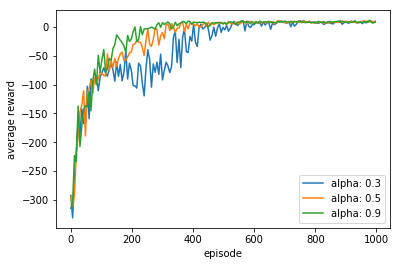

In [28]:
plt.figure()
for alpha in [0.3, 0.5, 0.9]:
    obj_q_taxi_tmp = QLearning(env=taxi_env, gamma=0.8, alpha=alpha, episodes=int(1e3), num_iter=100)
    _, lreward_q_taxi_tmp = obj_q_taxi_tmp.q_learn(verbose=False)
    epis_tmp, avg_reward_tmp = obj_q_taxi_tmp.get_avg_reward(lreward_q_taxi_tmp, 6)
    plt.plot(epis_tmp, avg_reward_tmp, label='alpha: '+str(alpha))
plt.xlabel('episode')
plt.ylabel('average reward')
plt.legend()
plt.show()    

### FrozenLake2

In [29]:
MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "10x10": [
        "SFFFFFFFFF",
        "FFFFFFFFFF",
        "FFFHFFFFFF",
        "FFFFFHFFFF",
        "FFFHFFFFFF",
        "FHHFFFHFFF",
        "FHFFHFHFFH",
        "FFFHFFFFFF",
        "FFFFFHFFFF",
        "FFFFFHFHFG",
    ]
}

In [30]:
register(
    id='FrozenLakeLarge-v2',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'desc': MAPS['10x10'], 'is_slippery': True},
)

In [31]:
fl2_env = gym.make('FrozenLakeLarge-v2')
fl2_env = fl2_env.unwrapped

#### value iteration

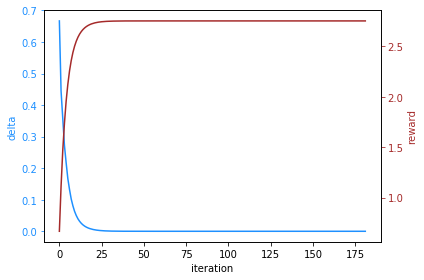

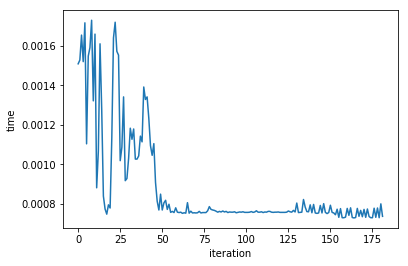

In [32]:
obj_vi_fl2 = ValueIter(env=fl2_env, gamma=0.8)
val_vi_fl2, ldelta_vi_fl2, lreward_vi_fl2, ltime_vi_fl2 = obj_vi_fl2.value_iter()
obj_vi_fl2.plot(ldelta_vi_fl2, lreward_vi_fl2, ltime_vi_fl2)

In [33]:
policy_vi_fl2 = obj_vi_fl2.get_policy(val_vi_fl2)
print('avg_score: ',eval_policy(env=fl2_env, policy=policy_vi_fl2, gamma=0.8))
run_policy(env=fl2_env, policy=policy_vi_fl2, gamma=0.8,render=True)

avg_score:  2.5394814595845694e-05

SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Up)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Up)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Right)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Right)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Up)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Up)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Right)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Right)
SFFFFFFFFF
FFFFF

0.0

#### policy iteration

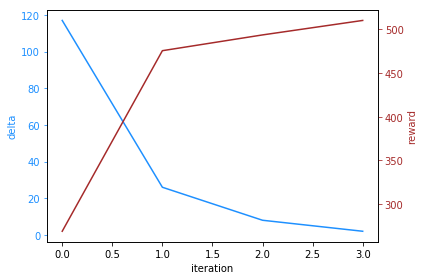

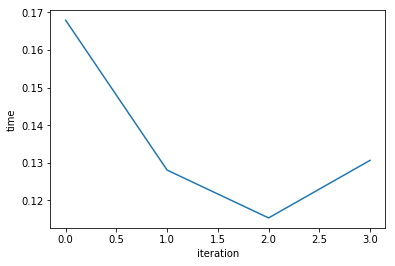

In [34]:
obj_pi_fl2 = PolicyIter(env=fl2_env, gamma=0.8)
policy_pi_fl2, ldelta_pi_fl2, lreward_pi_fl2, ltime_pi_fl2 = obj_pi_fl2.policy_iter()
obj_pi_fl2.plot(ldelta_pi_fl2, lreward_pi_fl2, ltime_pi_fl2)

In [35]:
print('avg_score: ',eval_policy(env=fl2_env, policy=policy_pi_fl2, gamma=0.8))
run_policy(env=fl2_env, policy=policy_pi_fl2, gamma=0.8,render=True)

avg_score:  2.5394814595845694e-05

SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Up)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Up)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Right)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Right)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Up)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Up)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Right)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Right)
SFFFFFFFFF
FFFFF

0.0

#### q learning

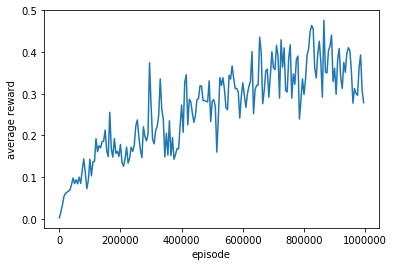

In [36]:
obj_q_fl2 = QLearning(env=fl2_env, gamma=0.8, alpha=0.9, episodes=int(1e6), num_iter=1000)
q_q_fl2, lreward_q_fl2 = obj_q_fl2.q_learn(verbose=False)
obj_q_fl2.plot(lreward_q_fl2, size=5000)

In [37]:
policy_q_fl2 = obj_q_fl2.get_policy(q_q_fl2)
print('avg_score: ',eval_policy(env=fl2_env, policy=policy_q_fl2, gamma=0.8))
run_policy(env=fl2_env, policy=policy_q_fl2, gamma=0.8,render=True)

avg_score:  6.2210127388097615e-06

SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Down)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Up)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Left)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Right)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Left)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Right)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Up)
SFFFFFFFFF
FFFFFFFFFF
FFFHFFFFFF
FFFFFHFFFF
FFFHFFFFFF
FHHFFFHFFF
FHFFHFHFFH
FFFHFFFFFF
FFFFFHFFFF
FFFFFHFHFG
  (Left)
SFFFFFFFFF
FFF

0.0

#### compare frozenlake

In [38]:
def compare_plot(frozenlake_s, frozenlake_l, xlabel, ylabel):
    plt.figure()
    plt.plot(list(range(len(frozenlake_s))), frozenlake_s, label='small frozenlake')
    plt.plot(list(range(len(frozenlake_l))), frozenlake_l, label='large frozenlake')
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()   

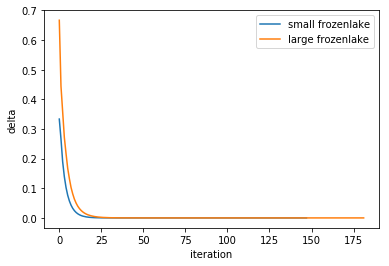

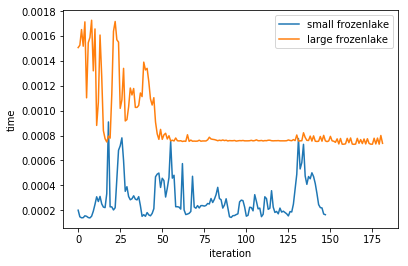

In [39]:
compare_plot(ldelta_vi_fl0, ldelta_vi_fl2, 'iteration', 'delta')
compare_plot(ltime_vi_fl0, ltime_vi_fl2, 'iteration', 'time')

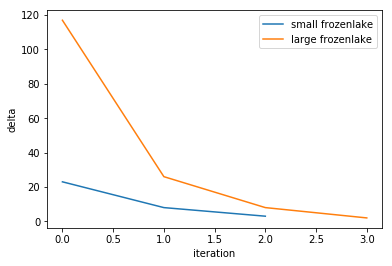

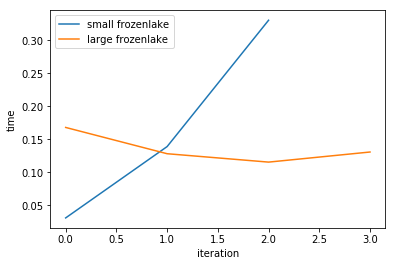

In [40]:
compare_plot(ldelta_pi_fl0, ldelta_pi_fl2, 'iteration', 'delta')
compare_plot(ltime_pi_fl0, ltime_pi_fl2, 'iteration', 'time')

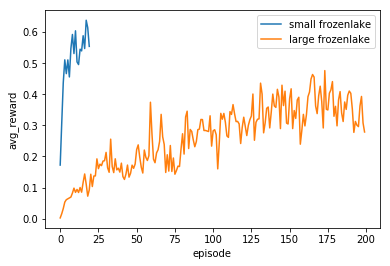

In [41]:
epis_fl0, avg_reward_fl0 = obj_q_fl0.get_avg_reward(lreward_q_fl0, 5000)
epis_fl2, avg_reward_fl2 = obj_q_fl2.get_avg_reward(lreward_q_fl2, 5000)
compare_plot(avg_reward_fl0, avg_reward_fl2, 'episode', 'avg_reward')

In [42]:
policy_pi_fl0

array([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])

In [43]:
directions = { 3: '⬆', 2: '➡', 1: '⬇', 0: '⬅' }

In [44]:
def policy_map(k, policy):
    grid = MAPS[str(k)+'x'+str(k)]
    dir_mapper = { 3: '⬆', 2: '➡', 1: '⬇', 0: '⬅' }
    for row_idx in range(len(grid)):
        for col_idx in range(len(grid[row_idx])):
            direction = policy[k*row_idx + col_idx]
            print(grid[row_idx][col_idx],dir_mapper[direction], end=' ')
        print()

In [45]:
policy_map(4, policy_vi_fl0)

S ➡ F ⬆ F ➡ F ⬆ 
F ⬅ H ⬅ F ⬅ H ⬅ 
F ⬆ F ⬇ F ⬅ H ⬅ 
H ⬅ F ➡ F ⬇ G ⬅ 


In [46]:
policy_map(4, policy_pi_fl0)

S ⬅ F ⬆ F ⬆ F ⬆ 
F ⬅ H ⬅ F ⬅ H ⬅ 
F ⬆ F ⬇ F ⬅ H ⬅ 
H ⬅ F ➡ F ⬇ G ⬅ 


In [47]:
policy_map(10, policy_vi_fl2)

S ⬆ F ➡ F ➡ F ➡ F ➡ F ➡ F ➡ F ➡ F ➡ F ➡ 
F ⬆ F ➡ F ⬆ F ⬆ F ➡ F ➡ F ➡ F ⬇ F ⬇ F ⬇ 
F ⬆ F ➡ F ⬅ H ⬅ F ➡ F ⬆ F ➡ F ⬇ F ⬇ F ⬇ 
F ⬆ F ⬆ F ⬆ F ⬇ F ⬅ H ⬅ F ➡ F ⬇ F ⬇ F ⬇ 
F ➡ F ⬆ F ⬅ H ⬅ F ➡ F ⬇ F ⬆ F ➡ F ⬇ F ⬇ 
F ⬅ H ⬅ H ⬅ F ⬇ F ⬆ F ⬅ H ⬅ F ➡ F ⬇ F ⬆ 
F ⬅ H ⬅ F ⬇ F ⬅ H ⬅ F ⬅ H ⬅ F ➡ F ⬅ H ⬅ 
F ⬇ F ⬇ F ⬅ H ⬅ F ⬇ F ⬆ F ⬇ F ➡ F ⬇ F ⬇ 
F ⬇ F ⬇ F ⬇ F ⬇ F ⬅ H ⬅ F ➡ F ⬆ F ➡ F ⬇ 
F ⬇ F ➡ F ➡ F ➡ F ⬅ H ⬅ F ⬅ H ⬅ F ➡ G ⬅ 


In [48]:
policy_map(10, policy_vi_fl2)

S ⬆ F ➡ F ➡ F ➡ F ➡ F ➡ F ➡ F ➡ F ➡ F ➡ 
F ⬆ F ➡ F ⬆ F ⬆ F ➡ F ➡ F ➡ F ⬇ F ⬇ F ⬇ 
F ⬆ F ➡ F ⬅ H ⬅ F ➡ F ⬆ F ➡ F ⬇ F ⬇ F ⬇ 
F ⬆ F ⬆ F ⬆ F ⬇ F ⬅ H ⬅ F ➡ F ⬇ F ⬇ F ⬇ 
F ➡ F ⬆ F ⬅ H ⬅ F ➡ F ⬇ F ⬆ F ➡ F ⬇ F ⬇ 
F ⬅ H ⬅ H ⬅ F ⬇ F ⬆ F ⬅ H ⬅ F ➡ F ⬇ F ⬆ 
F ⬅ H ⬅ F ⬇ F ⬅ H ⬅ F ⬅ H ⬅ F ➡ F ⬅ H ⬅ 
F ⬇ F ⬇ F ⬅ H ⬅ F ⬇ F ⬆ F ⬇ F ➡ F ⬇ F ⬇ 
F ⬇ F ⬇ F ⬇ F ⬇ F ⬅ H ⬅ F ➡ F ⬆ F ➡ F ⬇ 
F ⬇ F ➡ F ➡ F ➡ F ⬅ H ⬅ F ⬅ H ⬅ F ➡ G ⬅ 
